# Outlier 2021: Inching back to normality

Usually, I put together a round up at the end of the year. Because of the discussion about the evolution of prices on Reddit and Discord, I am putting up a preliminary version up earlier, to help the discourse became a bit more grounded in data.

In [1]:
import pandas as pd
import numpy as np
import scipy
import os
import os.path
from IPython.display import display, HTML
import utils
import plots
import altair as alt

alt.renderers.enable('mimetype')

year = 2021
# df_all = utils.outlier_df('../../outlier-data.csv', year)
df_all = utils.outlier_df('../../../outlier/public/outlier-data.csv', year)

In [2]:
rel = df_all.iloc[0]['Release'].to_pydatetime()
text = f"""<p><i>(Provisional analysis of Outlier 2021 drops up to {rel.strftime("%b %d, %Y")})</i></p>"""
display(HTML(text))

**Contents**
* *The Rundown*

In [3]:
# Filter to Clothes
def type_to_kind(drop_type):
    if drop_type == "T-Shirt" or drop_type == "Shirt" or drop_type == "Tank Top":
        return "Top"
    if drop_type == "Pants" or drop_type == "Shorts":
        return "Bottom"
    return "Layer"


def row_to_subkind(row):
    drop_type = row['Type']
    if drop_type == "T-Shirt" or drop_type == "Shirt":
        pass
    elif drop_type == "Pants" or drop_type == "Shorts":
        pass
    elif drop_type == "Tank Top":
        drop_type = 'T-Shirt'
    else:
        drop_type = "Layer"
    exp = "Exp" if row['Exp'] else "Regular"
    return "{}/{}".format(drop_type, exp)


def object_type_to_kind(drop_type):
    if drop_type == "Backpack" or drop_type == "Bag" or drop_type == "Dopp Kit" \
       or drop_type == "Dufflebag" or drop_type == "Pouch":
        return "Bag"
    if drop_type == "Balaclava" or drop_type == "Bandana" or drop_type == "Scarf":
        return "Scarf/Bandana"
    if drop_type == "Cap" or drop_type == "Hat" or drop_type == "Hood":
        return "Headgear"
    if drop_type == "Bathrobe" or drop_type == "Robe" or drop_type == "Towel" \
       or drop_type == "Outerwear" or drop_type == "Keychain" or drop_type == "Socks":
        return "Misc"
    if drop_type == "Mask" or drop_type == "Belt":
        return drop_type     
    return "Misc"


def drops_to_clothes_drops(df):
    df_clothes = pd.DataFrame(df.loc[df['Category'] == 'Clothes', :])
    df_clothes['Type'] = df_clothes['Type'].replace({'Sweatshirt':'Sweater'})
    df_clothes["Kind"] = df_clothes['Type'].apply(type_to_kind)
    df_clothes["Subkind"] = df_clothes.apply(row_to_subkind, axis=1)
    return df_clothes


# Define some reused frames
all_products_df = utils.drops_to_products(df_all, ['Year', 'Product'], 2021)
df_all['ColorCount'] = df_all['Colors'].str.split(',').dropna().apply(lambda d: len(d))

df_clothes = drops_to_clothes_drops(df_all)
clothes_products_df = utils.drops_to_products(df_clothes, ['Year', 'Product', 'Kind'], 2021)

df_objects = pd.DataFrame(df_all.loc[df_all['Category'] == 'Objects', :])
df_objects["Kind"] = df_objects['Type'].apply(object_type_to_kind)
objects_products_df = utils.drops_to_products(df_objects, ['Year', 'Product', 'Kind'], 2021)


kind_sort_order = ['Bottom', 'Top', 'Layer']
object_kind_sort_order = ['Bag', 'Mask', 'Scarf/Bandana', 'Headgear', 'Belt', 'Other']
year_sort = list(range(year, 2012, -1))
recent_year_sort = list(range(year, 2017, -1))
adjusted_price_col = f"Price-{year}"

In [4]:
ytd_dt = df_all.iloc[0]['Release']
ytd_mask = (df_all['Release'].dt.month < ytd_dt.month) | (
    (df_all['Release'].dt.month == ytd_dt.month) &
    (df_all['Release'].dt.day <= ytd_dt.day))
ytd_df = df_all.loc[ytd_mask]
# ytd_df.head()

# *The Rundown*

Every year we have some of the same questions, so let us start with the rundown and get these out of the way.

- How many drops were there?
- Is Outlier getting more expensive?
- What were the most dropped items?
- What were the most used fabrics?

# How many drops were there?

We are not yet at the end of the year, but we can see how things have been progressing so far in 2021 compared to previous years.

So far, 2021 lags behind the last six years in terms of number of drops by this point in the year. It is closest to 2015 in terms of number of drops and products.

In [5]:
# rel_per_year_df = pd.DataFrame(df_all.groupby('Year').count()['Product'])
# prod_per_year_df = pd.DataFrame(all_products_df.groupby('Year').count()['Release']
# )

# (plots.plot_with_yoy(rel_per_year_df, 'Product', 'Drops').properties(title='Number of Drops over Time') 
# & plots.plot_with_yoy(prod_per_year_df, 'Release', 'Products').properties(title='Number of Products over Time') )

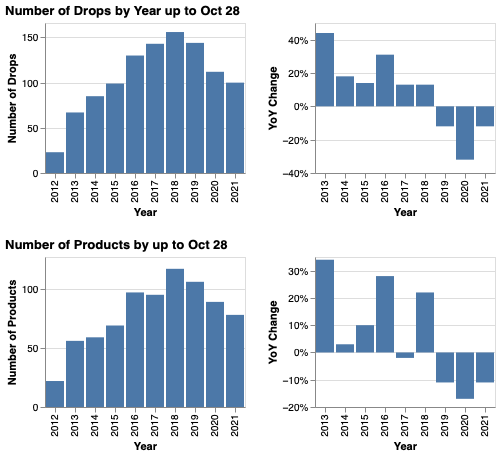

In [6]:
# rel_per_year_df = pd.DataFrame(df_all.groupby('Year').count()['Product'])
# prod_per_year_df = pd.DataFrame(all_products_df.groupby('Year').count()['Release']
# )

# (plots.plot_with_yoy(rel_per_year_df, 'Product', 'Drops').properties(title='Number of Drops over Time') 
# & plots.plot_with_yoy(prod_per_year_df, 'Release', 'Products').properties(title='Number of Products over Time') )

ytd_all_products_df = utils.drops_to_products(ytd_df, ['Year', 'Product'], 2021)
rel_per_year_df = pd.DataFrame(ytd_df.groupby('Year').count()['Product'])
prod_per_year_df = pd.DataFrame(ytd_all_products_df.groupby('Year').count()['Release']
)

(plots.plot_with_yoy(rel_per_year_df, 'Product', 'Drops').properties(title=f"Number of Drops by Year up to {rel.strftime('%b %d')}") 
& plots.plot_with_yoy(prod_per_year_df, 'Release', 'Products').properties(title=f"Number of Products by up to {rel.strftime('%b %d')}"))

## Breakdown by Category

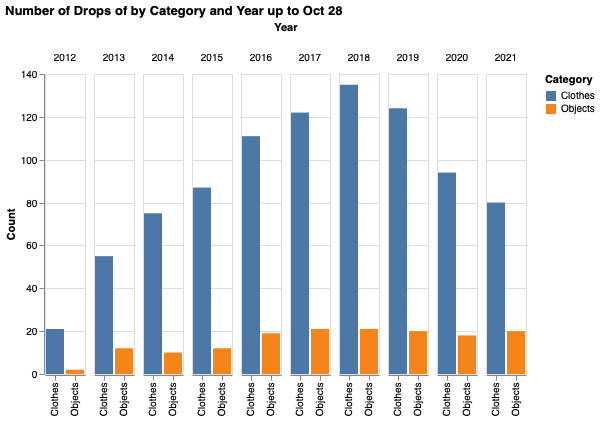

In [7]:
# tdf = df_all.groupby(['Category', 'Year']).count()['Release'].reset_index()
tdf = ytd_df.groupby(['Category', 'Year']).count()['Release'].reset_index()
tdf.columns = ['Category', 'Year', 'Count']
alt.Chart(tdf, width=40).mark_bar().encode(
    x=alt.X('Category:N', sort=kind_sort_order, title=None),
    y='Count:Q',
    color=alt.Color('Category:N', sort=kind_sort_order),
    column='Year:O',
    tooltip=['Count', ]
).configure_facet(spacing=7).properties(title=f"Number of Drops of by Category and Year up to {rel.strftime('%b %d')}")

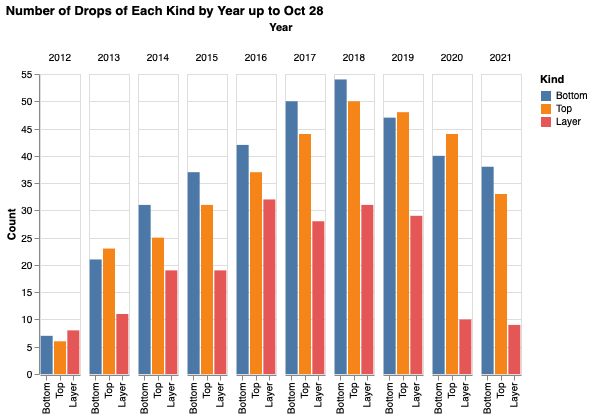

In [8]:
# tdf = df_clothes.groupby(['Kind', 'Year']).count()['Release'].reset_index()
tdf = drops_to_clothes_drops(ytd_df).groupby(['Kind', 'Year']).count()['Release'].reset_index()
tdf.columns = ['Kind', 'Year', 'Count']
alt.Chart(tdf, width=40).mark_bar().encode(
    x=alt.X('Kind:N', sort=kind_sort_order, title=None),
    y='Count:Q',
    color=alt.Color('Kind:N', sort=kind_sort_order),
    column='Year:O',
    tooltip=['Count', ]
).configure_facet(spacing=7).properties(title=f"Number of Drops of Each Kind by Year up to {rel.strftime('%b %d')}")

## Breakdown by Quarter

Look at the drops by quarter brings the picture into clearer focus. From the previous plots, it seems that 2021 is lagging behind the more-heavily-pandemic-impacted year of 2020, but looking at it by quarter shows why this is. 2020 Q1, which the COVID-pandemic only lightly impinged upon, was huge, much bigger than any previous Q1. 2021 Q2 and Q3 had more drops than 2020, but not by enough of a margin to make up the deficit from Q1.

In any case, number of drops are slowly recovering in 2021, but still quite a way off from where you would expect given the pre-COVID trend.

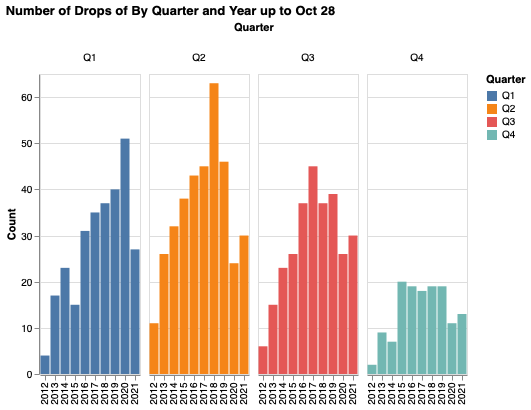

In [9]:
# tdf = df_all.groupby(['Quarter', 'Year']).count()['Release'].reset_index()
tdf = ytd_df.groupby(['Quarter', 'Year']).count()['Release'].reset_index()
tdf = tdf.rename(columns={"Release": "Count"})
alt.Chart(tdf, width=100).mark_bar().encode(
    x=alt.X('Year:N', sort=kind_sort_order, title=None),
    y='Count:Q',
    color=alt.Color('Quarter:N', sort=kind_sort_order),
    column='Quarter:O',
    tooltip=['Year', 'Count']
).configure_facet(spacing=7).properties(title=f"Number of Drops of By Quarter and Year up to {rel.strftime('%b %d')}")

## Time between drops by category

Say you want a pair of pants or shorts from Outlier? How long do you have to wait for the next drop?

In [10]:
def since_last_kind_df(clothes_drops_df, kind):
    tdf = clothes_drops_df[clothes_drops_df['Kind'] == kind]
    columns = ['Product', 'Type', 'Category', 'Kind', 'Year', 'Price', adjusted_price_col]
    tdf = tdf.set_index(columns)
    tdf = tdf.set_index('Release', drop=False, append=True)
    tser = tdf['Release'].diff().shift(-1)
    tser = tser * -1 / np.timedelta64(1, 'D')
    tser = pd.to_numeric(tser.dropna(), downcast='integer')
    tser = tser[tser > 0]
    tser.name = 'Since Last'
    return tser.reset_index()

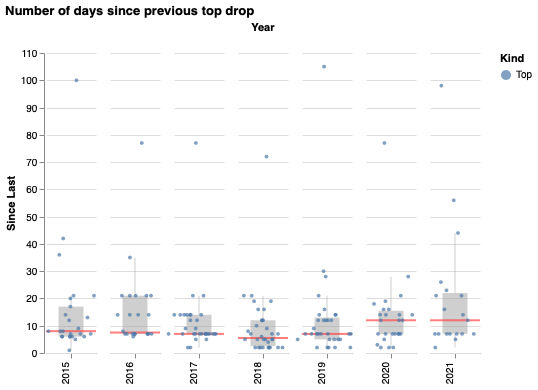

In [11]:
tdf = drops_to_clothes_drops(ytd_df)
ttdf = since_last_kind_df(tdf, 'Top')
ttdf = ttdf[ttdf['Year'] > 2014]
plots.facetted_scatter(ttdf, 
                       'Kind', 
                       kind_sort_order, 
                       'Since Last').properties(title='Number of days since previous top drop')

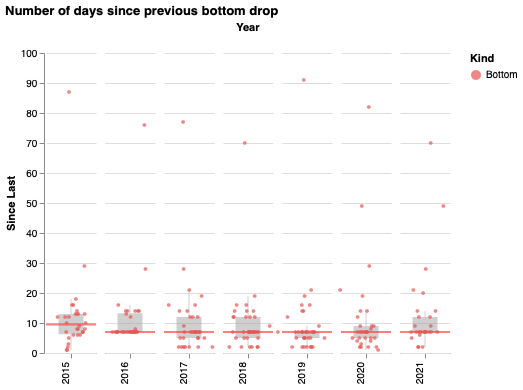

In [12]:
ttdf = since_last_kind_df(tdf, 'Bottom')
ttdf = ttdf[ttdf['Year'] > 2014]
plots.facetted_scatter(ttdf, 
                       'Kind', 
                       kind_sort_order, 
                       'Since Last',
                       color_scale=alt.Scale(range=['#e45756'])).properties(title='Number of days since previous bottom drop')

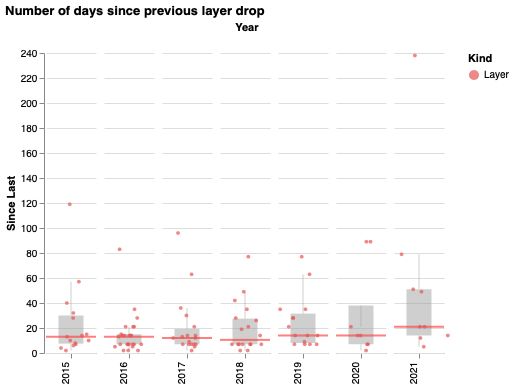

In [13]:
ttdf = since_last_kind_df(tdf, 'Layer')
ttdf = ttdf[ttdf['Year'] > 2014]
plots.facetted_scatter(ttdf, 
                       'Kind', 
                       kind_sort_order, 
                       'Since Last',
                       color_scale=alt.Scale(range=['#e45756'])).properties(title='Number of days since previous layer drop')

## Prices

Are Outlier products getting more expensive? In aggregate, no they are not getting more expensive: the median nominal price is $198, same as it was last year, and lower than it was between 2016&ndash;2019. But the more nuanced answer is: it depends on how you look at it.

The following plots show the price of products, grouped by year. Each dot is the *maximum nominal price* of one product within a calendar year. The category of product is indicated by the color of the dot. The red lines show the *median nominal price* for that year. The gray boxes indicate the 25&ndash;75 percentiles, so half of all drop prices for the year fall in that range. Mousing over a dot will show the name, nominal, and inflation-adjusted prices for the product.

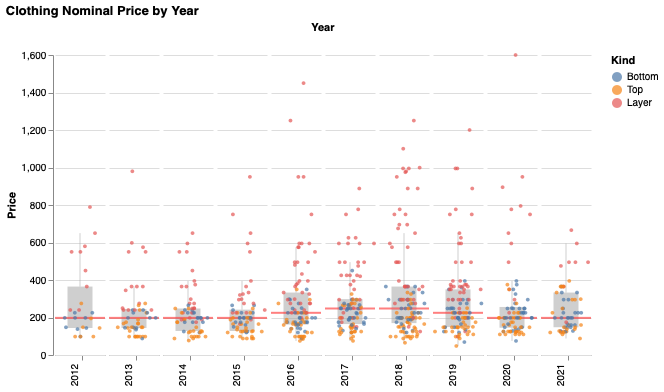

In [14]:
plots.price_plot(clothes_products_df, 'Kind', kind_sort_order).properties(title='Clothing Nominal Price by Year')

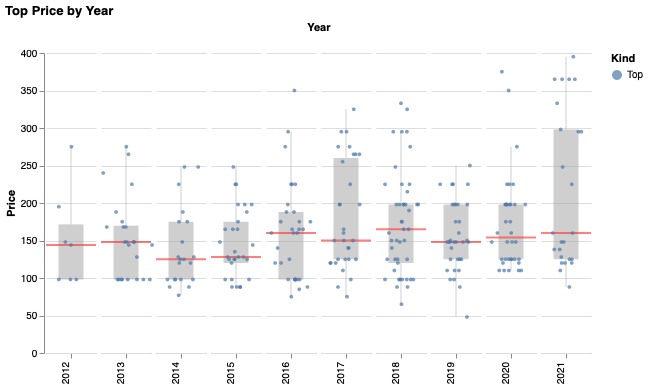

In [15]:
plots.price_plot(clothes_products_df[clothes_products_df['Kind'] == 'Top'], 
                 'Kind', 
                 kind_sort_order).properties(title='Top Price by Year')

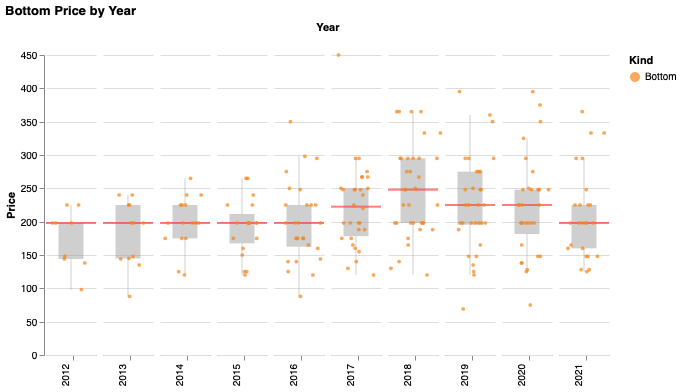

In [16]:
plots.price_plot(clothes_products_df[clothes_products_df['Kind'] == 'Bottom'], 
                 'Kind', 
                 kind_sort_order,
                 color_scale=alt.Scale(range=['#f58518'])).properties(title='Bottom Price by Year')

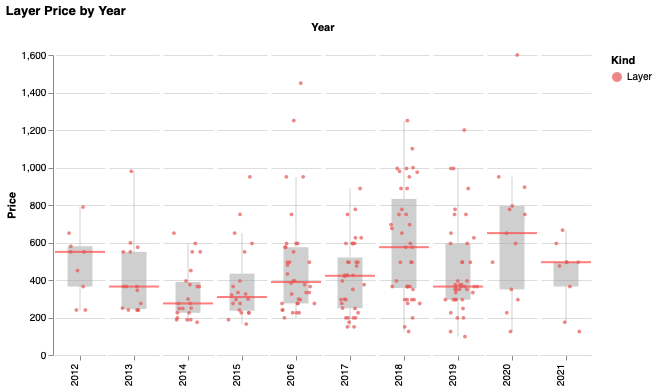

In [17]:
plots.price_plot(clothes_products_df[clothes_products_df['Kind'] == 'Layer'], 
                 'Kind', 
                 kind_sort_order,
                 color_scale=alt.Scale(range=['#e45756'])).properties(title='Layer Price by Year')

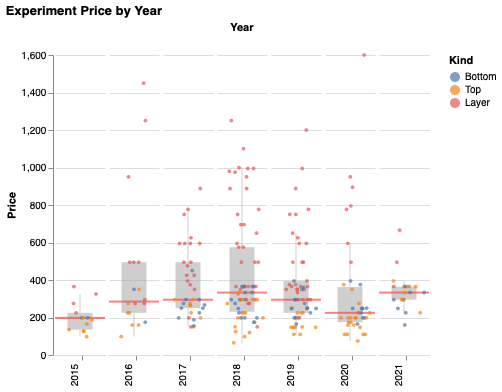

In [18]:
plots.price_plot(df_clothes[(df_clothes['Exp'] == True) & 
                            (df_clothes['Release'].dt.year > 2014)],
                 'Kind', 
                 kind_sort_order).properties(title='Experiment Price by Year')

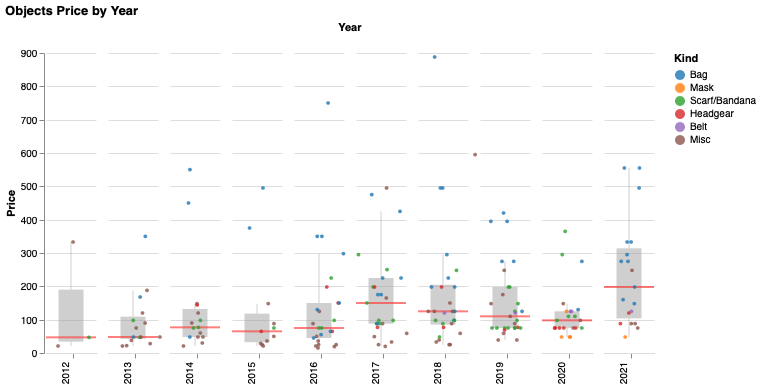

In [19]:
plots.price_plot(objects_products_df, 'Kind', object_kind_sort_order, 'Price',
                 'category10', 15, 0.8).properties(title='Objects Price by Year')

## Inflation-adjusted prices

The plots in the previous section used nominal prices. But $200 bought more in 2012 than it does in 2021, and a clearer understanding of the price evolution requires compensating for inflation. That is what the following versions of the plots do. They are the same as the ones above, except that the prices are adjusted for inflation using data from the [St. Louis Fed](https://fred.stlouisfed.org/series/PCEPILFE).

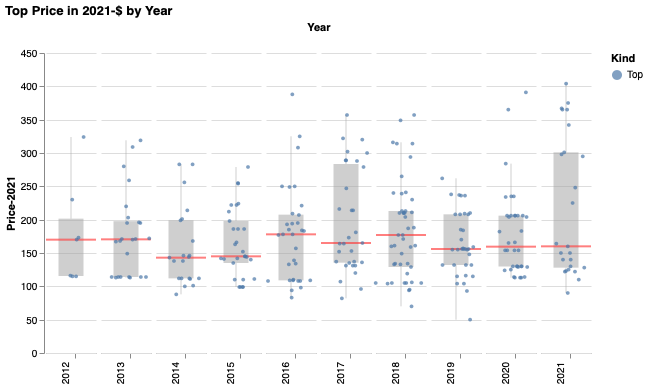

In [20]:
plots.price_plot(clothes_products_df[clothes_products_df['Kind'] == 'Top'], 
                 'Kind', 
                 kind_sort_order, f"Price-{year}").properties(
                 title=f"Top Price in {year}-$ by Year")

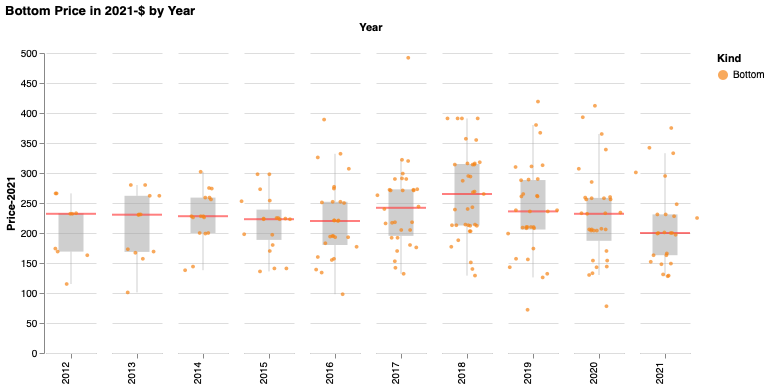

In [21]:
plots.price_plot(clothes_products_df[clothes_products_df['Kind'] == 'Bottom'], 
                 'Kind', 
                 kind_sort_order, f"Price-{year}",
                 color_scale=alt.Scale(range=['#f58518'])).properties(
                 title=f"Bottom Price in {year}-$ by Year")

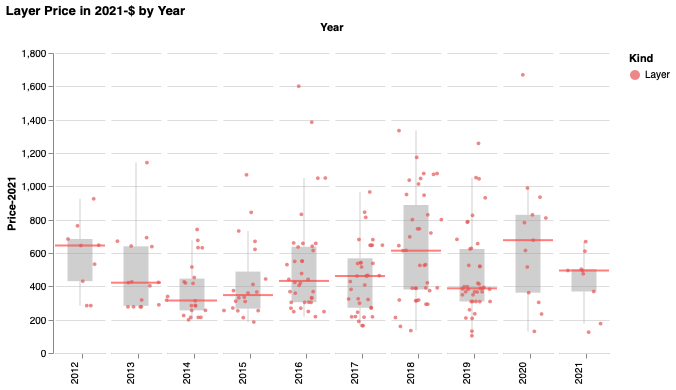

In [22]:
plots.price_plot(clothes_products_df[clothes_products_df['Kind'] == 'Layer'], 
                 'Kind', 
                 kind_sort_order, f"Price-{year}",
                 color_scale=alt.Scale(range=['#e45756'])).properties(
                 title=f"Layer Price in {year}-$ by Year")

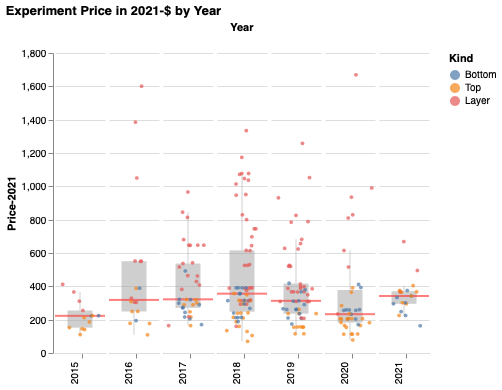

In [23]:
plots.price_plot(df_clothes[(df_clothes['Exp'] == True) & 
                            (df_clothes['Release'].dt.year > 2014)],
                 'Kind', 
                 kind_sort_order, f"Price-{year}").properties(
                 title=f"Experiment Price in {year}-$ by Year")

## Reups

What products got re-upped in 2020? The reups are probably more indicative of what was possible with the factories that were open and the fabric that was available, and it does not provide much insight into where Outlier is trying to go with their product line, but some might be curious nonetheless.

In [24]:
reups = []
index = []
for name, tdf in df_clothes.groupby("Product"):
    drops = tdf.groupby('Year').count()['Release']
    cat = tdf['Type'].iloc[0]
    kind = tdf['Kind'].iloc[0]

    # Products dropped in 2012 - 2013
    if drops.loc[2012:2013].sum() > 0 and tdf['MWU'].iloc[0] != 'Women':
        index.append((kind, cat, name))
        reups.append(drops)
        continue
    # Add layers by default
    if kind == 'Layer' and tdf['MWU'].iloc[0] != 'Women':
        index.append((kind, cat, name))
        reups.append(drops)
        continue        
    # Products dropped in at least 3 times since 2014
    if drops.loc[2014:year].sum() > 2:
        index.append((kind, cat, name))
        reups.append(drops)
        continue
    # Products dropped at least 2 times in the last three years
    if drops.loc[2019:year].sum() > 1:
        index.append((kind, cat, name))
        reups.append(drops)
        continue
reups_df = pd.DataFrame(reups, index=pd.MultiIndex.from_tuples(index, names=['Kind', 'Type', 'Product']))
reups_df = reups_df.sort_index()
# reups_df.head()

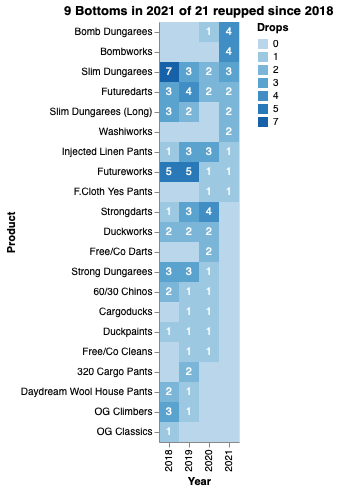

In [25]:
bottoms_df = reups_df.loc[('Bottom', 'Pants'), 2018:2021].dropna(axis=0, how='all')
title_bottoms = "{} Bottoms in 2021 of {} reupped since 2018".format(len(bottoms_df.loc[:,2021].dropna()), len(bottoms_df))
plots.drop_chart(bottoms_df.sort_values(list(range(2021, 2018, -1)), ascending=False)).properties(title=title_bottoms)

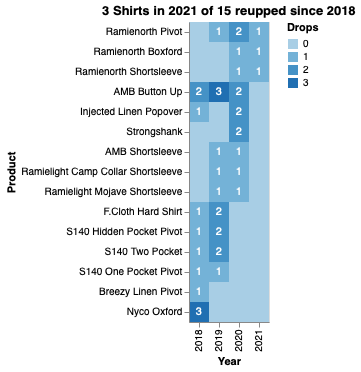

In [26]:
tops_df = reups_df.loc[('Top', 'Shirt'), 2018:2021].dropna(axis=0, how='all')
title_tops = "{} Shirts in 2021 of {} reupped since 2018".format(len(tops_df.loc[:,2021].dropna()), len(tops_df))
plots.drop_chart(tops_df.sort_values(list(range(2021, 2018, -1)), ascending=False)).properties(title=title_tops)

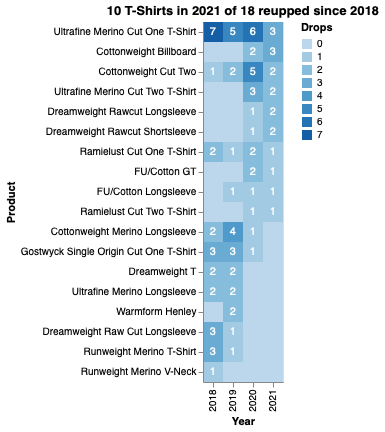

In [27]:
tops_df = reups_df.loc[('Top', 'T-Shirt'), 2018:2021].dropna(axis=0, how='all')
title_tops = "{} T-Shirts in 2021 of {} reupped since 2018".format(len(tops_df.loc[:,2021].dropna()), len(tops_df))
plots.drop_chart(tops_df.sort_values(list(range(2021, 2018, -1)), ascending=False)).properties(title=title_tops)